In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import rawpy
import numpy as np
import io
from PIL import Image
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

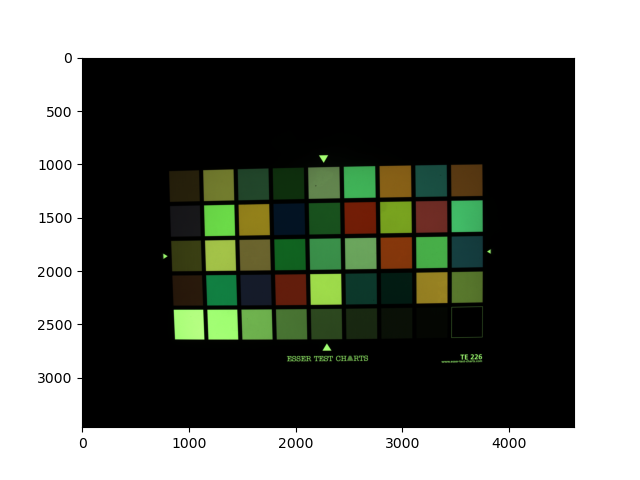

In [37]:
from digitalimage import DigitalImage

g81_img = DigitalImage("data\digital\P1480487.RW2", 2)
plt.figure()
plt.imshow(g81_img.raw)

In [38]:
g81_img.raw.shape

(3464, 4608, 3)

In [39]:
g81_img.thumbnail.shape

(3464, 4608, 3)

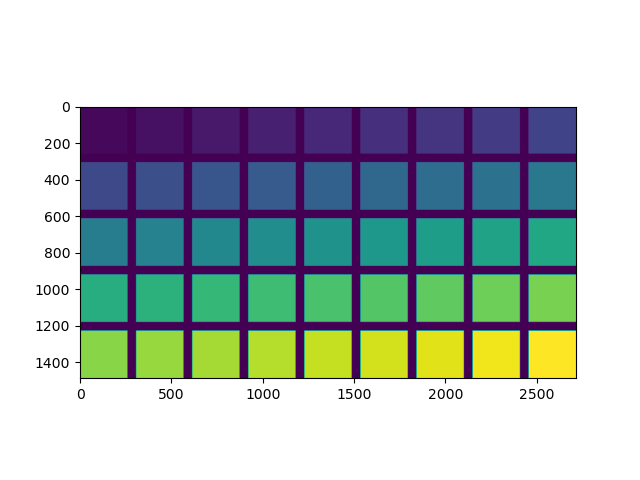

In [40]:
from colorchecker import ColorChecker

TE226 = ColorChecker(5, 9, 260, 47)
fig_checker = plt.figure()
plt.imshow(TE226.np_array)

In [41]:
def overlay_color_checker(image: np.ndarray, color_checker: np.ndarray, patch_alpha = 1, non_patch_alpha = 0.5):
    """
    builds an image where the position of the color_checker pattern patches is encoded as the transparency of the image
    :param image: source image on which to overlay the color_checker
    :param color_checker: color checker image to overlay. Needs to be at least as large as image
    :param patch_alpha: transparency value to use when at position of a color checker patch
    :param non_patch_alpha: transparency value to use when not at position of a color checker patch
    :return: a numpy array of 4 value pixels: (R, G, B, A) in range [0,1]
    """
    color_checker = (color_checker[:image.shape[0], :image.shape[1]] >= 1 ) * patch_alpha + (color_checker[:image.shape[0], :image.shape[1]] < 1 ) * non_patch_alpha
    return np.dstack((image, color_checker))


Output()

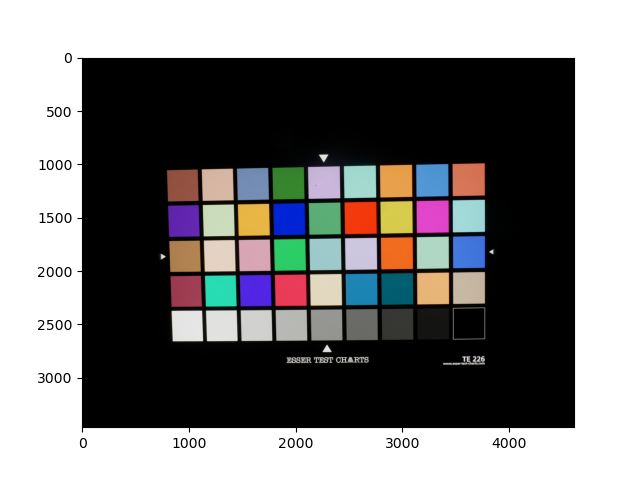

In [44]:
from matplotlib.backend_bases import MouseEvent
from colorchecker import ColorCheckerReadings
import ipywidgets as widgets

plt.close('all')

def identify_patches(image, reading: ColorCheckerReadings) -> None:
    """
    Gives a UI interface for the user to correctly identify the color chart on an image
    Top Left corner: left click;
    Top Right corner: right click;
    Bottom Left corner: shift + left click
    Bottom Right corner: shift + right click
    :param image: image to use for visualization. Does not have to be the same image as for the patch reading, but the colorchart needs to be at the same location on both images. Only acceots images with pixel values in range [0,1]
    :param reading: patch reading
    """
    fig_overlay = plt.figure()
    im_overlay = plt.imshow(image)
    out = widgets.Output()
    assert image.shape == reading.image.shape

    @out.capture()
    def onclick(event: MouseEvent):
        button_to_coord_map = {
            (1, None): reading.assign_top_left,
            (3, None): reading.assign_top_right,
            (1, 'shift'): reading.assign_bottom_left,
            (3, 'shift'): reading.assign_bottom_right
        }
        button_to_coord_map[(event.button,event.key)](event.xdata, event.ydata)
            
        if reading.patch_location_info is not None:
            im_overlay.set_data(overlay_color_checker(image, reading.patch_location_info))
            fig_overlay.canvas.draw_idle()
            
    display(out)
    cid = fig_overlay.canvas.mpl_connect('button_press_event', onclick)

TE226_g81_reading = ColorCheckerReadings(TE226, g81_img.raw)
identify_patches(g81_img.thumbnail, TE226_g81_reading)

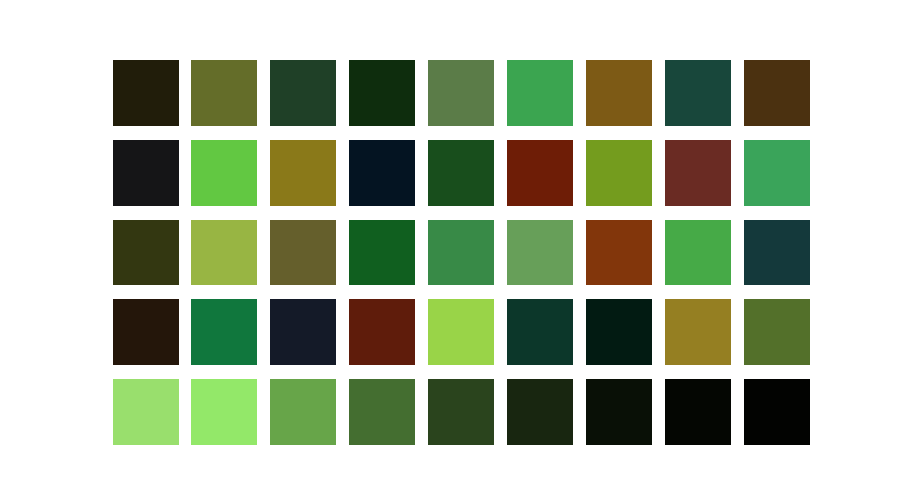

In [45]:
def plot_patches(reading: ColorCheckerReadings):  # todo add optional titles
    """
    plot the patch readings of a color chart
    :param reading: the ColorCheckerReading object which needs to have already extracted the patch data
    """
    assert reading.patch_data is not None
    plt.figure(figsize=(reading.color_checker.num_cols, reading.color_checker.num_rows))
    for i in range(reading.color_checker.num_rows):
        for j in range(reading.color_checker.num_cols):
            plt.subplot(reading.color_checker.num_rows, reading.color_checker.num_cols, i*reading.color_checker.num_cols+j+1)
            plt.imshow(
                reading.patch_data[
                    np.newaxis, np.newaxis, i*reading.color_checker.num_cols+j
                ]
            )
            plt.axis('off')

plot_patches(TE226_g81_reading)

# TIF processing pipeline

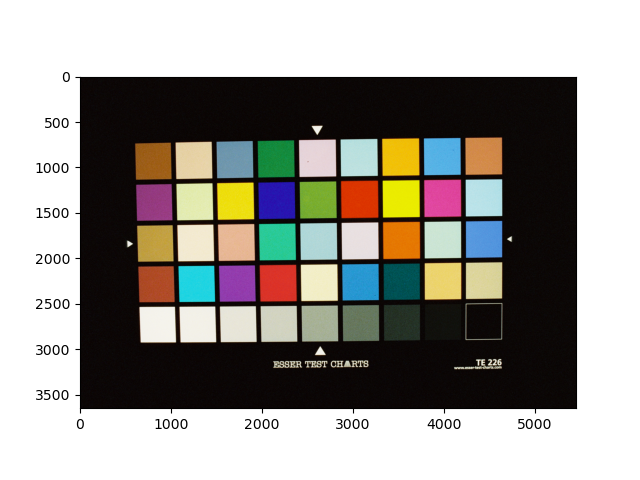

In [16]:
tif = Image.open("data/film/A002382raphael-R1-20-21.TIF")
tif_array = np.array(tif) / 255
plt.figure()
plt.imshow(tif_array)

Output()

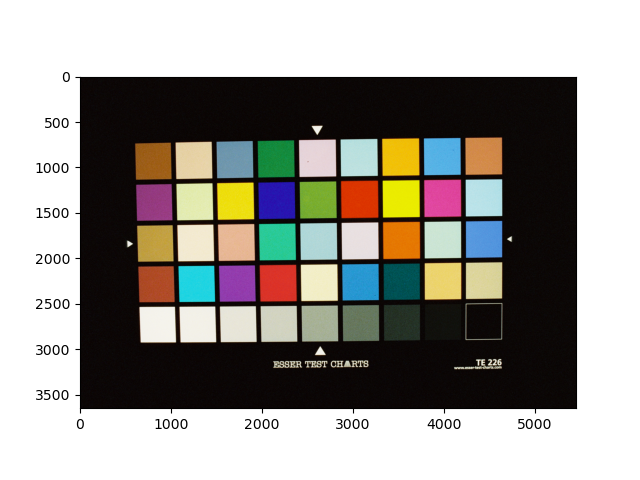

In [17]:
plt.close('all')
TE226_800t_reading = ColorCheckerReadings(TE226, tif_array)
identify_patches(tif_array, TE226_800t_reading)

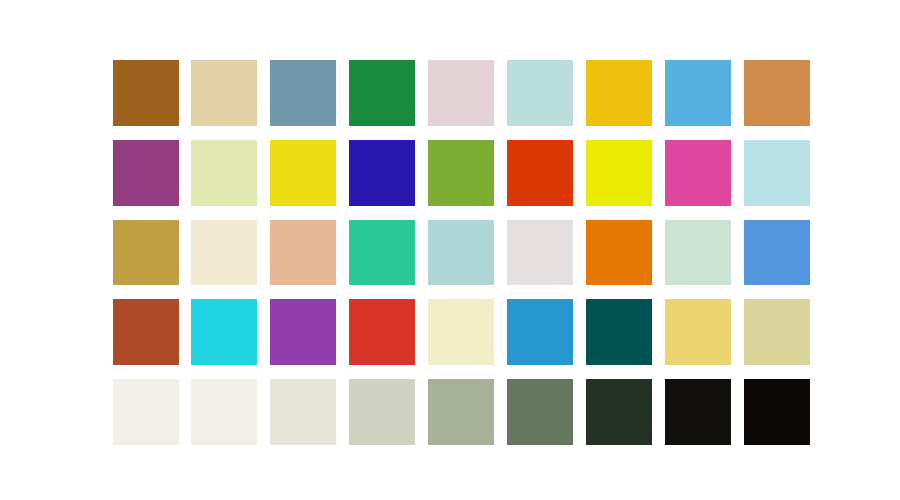

In [18]:
plot_patches(TE226_800t_reading)

## Linearize Tif

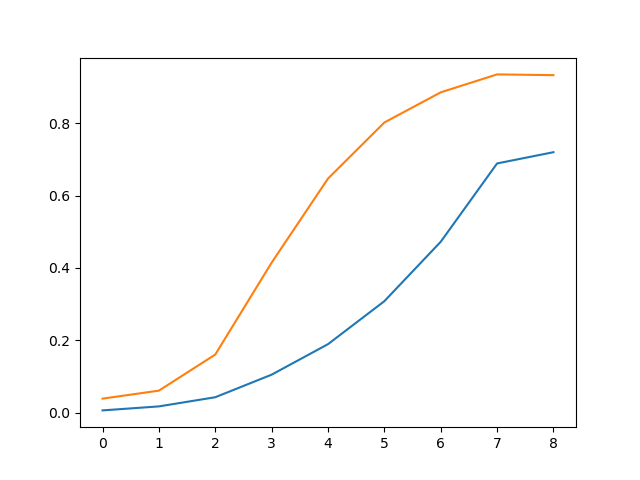

In [19]:
greyscale_g81_patches = np.average(TE226_g81_reading.patch_data[-9:], axis=1)
indices = np.argsort(greyscale_g81_patches)
sorted_g81_patches = np.take_along_axis(greyscale_g81_patches, indices, axis=0)
plt.figure()
plt.plot(sorted_g81_patches) 

greyscale_800t_patches = np.average(TE226_800t_reading.patch_data[-9:], axis=1)
sorted_800t_patches = np.take_along_axis(greyscale_800t_patches, indices, axis=0)
plt.plot(sorted_800t_patches)

array([4.25892268e-05, 1.00000000e+01, 2.22733886e-01, 4.74716199e-03])

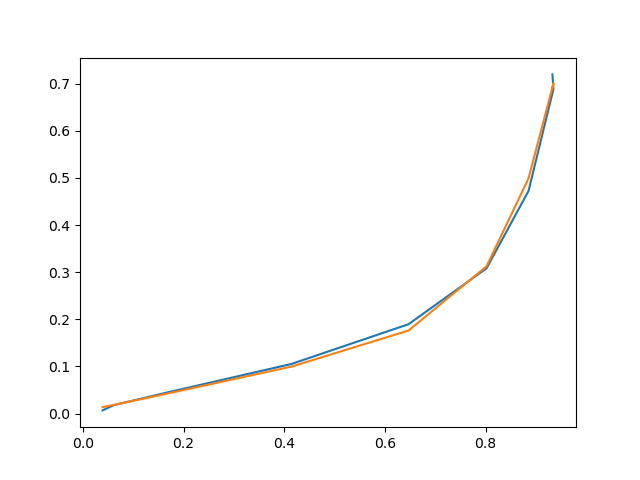

In [20]:
from scipy.optimize import curve_fit
from scipy.special import lambertw

def func(x, a, b, c, d):
    return a * np.exp(b * x) + c*x + d

def inv_func(y, a, b, c, d): # todo absorb error
    assert a != 0
    assert b != 0
    return np.float32((-c * lambertw((a*b*np.exp(b*(y-d)/c))/c)-b*d+b*y) / (b*c))

popt, pcov = curve_fit(func, sorted_800t_patches, sorted_g81_patches, bounds=(0, [10, 10, 10, 10]))
plt.figure()

plt.plot(sorted_800t_patches, sorted_g81_patches)
plt.plot(sorted_800t_patches, func(sorted_800t_patches, *popt),
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

popt

C:\Users\Shanzhaii\AppData\Local\Temp\ipykernel_22128\3190054271.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.float32((-c * lambertw((a*b*np.exp(b*(y-d)/c))/c)-b*d+b*y) / (b*c))


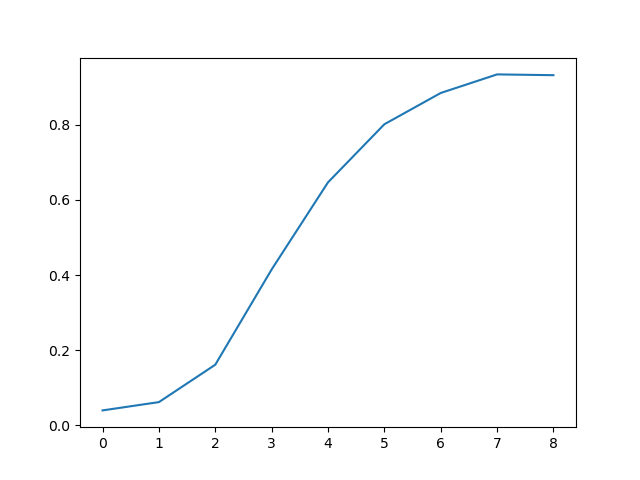

In [21]:
plt.figure()
plt.plot(inv_func(func(sorted_800t_patches, *popt), *popt))

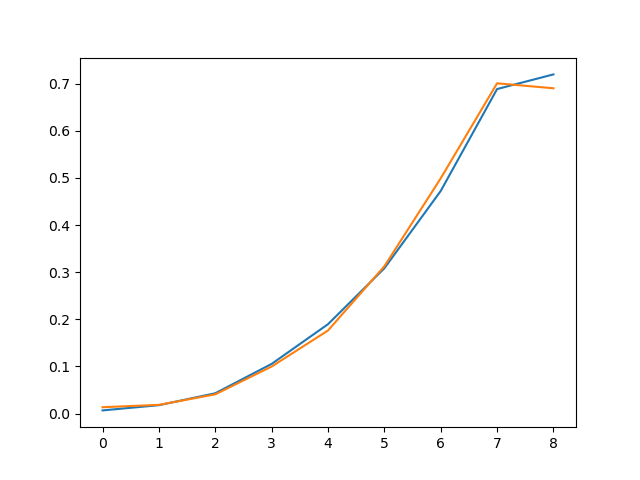

In [22]:
plt.figure()
plt.plot(sorted_g81_patches) # add legends
plt.plot(func(sorted_800t_patches, *popt)) # todo annotate

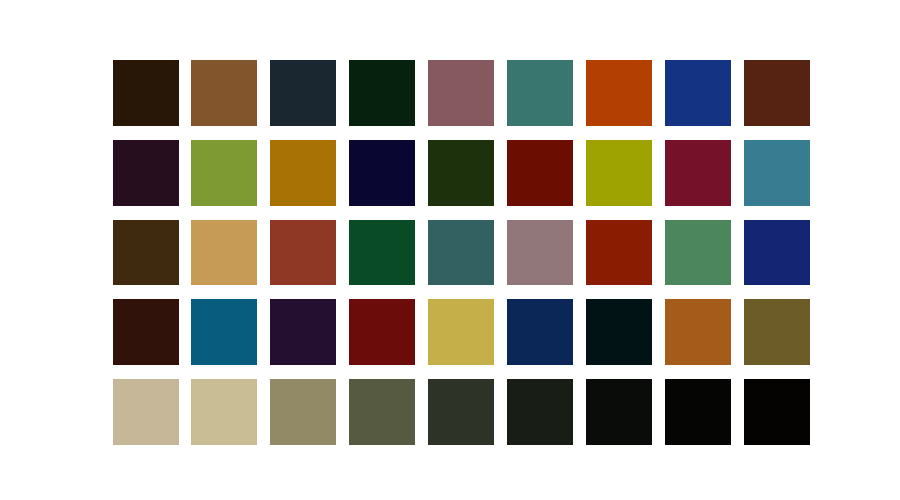

In [23]:
TE226_800t_linearized_reading = TE226_800t_reading.apply_transformation(func, popt)
plot_patches(TE226_800t_linearized_reading)

# Calculate Transfer Function

In [28]:
from colortransfer import ColorTransfer

poly = ColorTransfer(['r', 'g', 'b', 'rg', 'rb', 'gb', 'rr', 'gg', 'bb', 'rgb', '1'], TE226_g81_reading.patch_data, TE226_800t_linearized_reading.patch_data)

In [29]:
g81_modified_image = poly.apply(g81_img.raw, lambda image: inv_func(image, *popt))

C:\Users\Shanzhaii\AppData\Local\Temp\ipykernel_22128\3190054271.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.float32((-c * lambertw((a*b*np.exp(b*(y-d)/c))/c)-b*d+b*y) / (b*c))


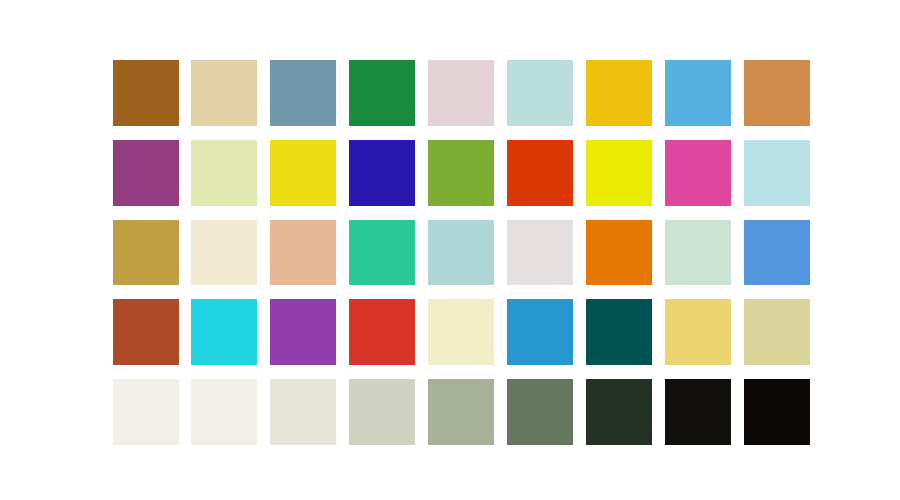

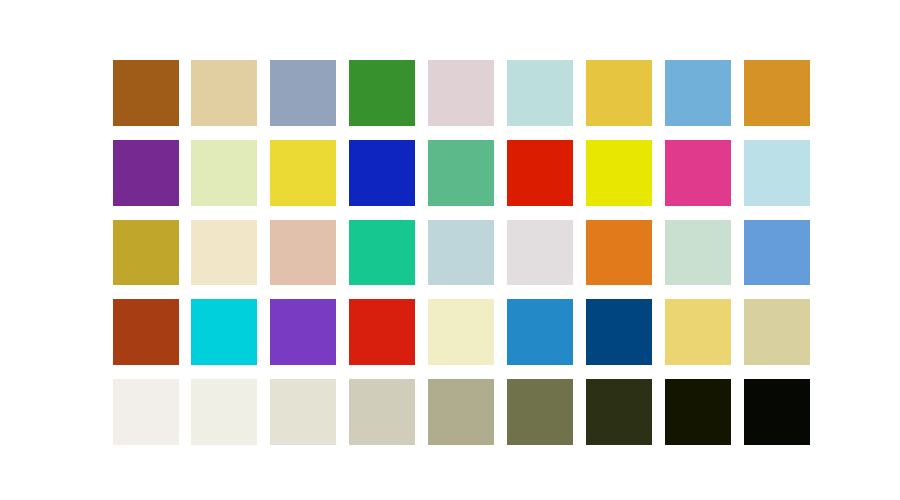

In [30]:
plt.close('all')
plot_patches(TE226_800t_reading) # todo add titles
TE226_G81_updated_readings = TE226_g81_reading.apply_new_image(g81_modified_image)
plot_patches(TE226_G81_updated_readings)

## Calculating Color Distance

In [31]:
np.sum(np.linalg.norm(TE226_800t_reading.patch_data - TE226_G81_updated_readings.patch_data, axis=1))
# sRGB inverse tif: 6.058066025950642
# raw tif: 10.354313048359437
# exponential fitting tif: 5.8196292612243505
# affine fitting tif: 5.123900047000643
# affine + bb = 5.038549887154095
# affine + bb + better fitting tif 4.132495471413496
# affine + better fitting tif 4.10758754330378

3.653810990198911

# Applying color transform

C:\Users\Shanzhaii\AppData\Local\Temp\ipykernel_22128\3190054271.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.float32((-c * lambertw((a*b*np.exp(b*(y-d)/c))/c)-b*d+b*y) / (b*c))


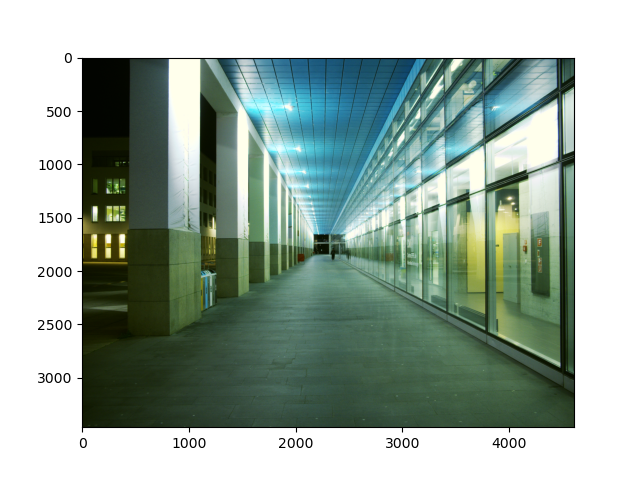

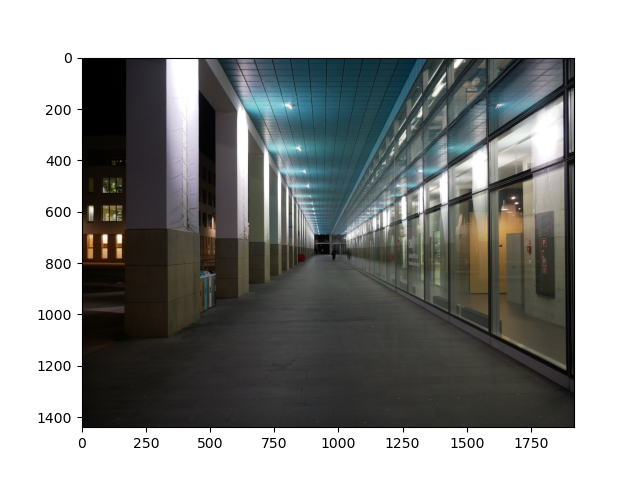

In [33]:
test_img = DigitalImage("data\digital\P1480512.RW2", 4)
modified = poly.apply(test_img.raw, lambda image: inv_func(image, *popt))
plt.figure()
plt.imshow(modified)
plt.figure()
plt.imshow(test_img.thumbnail)
Image.fromarray(np.uint8(modified*255)).save("out.png")

# Failed tests

In [ ]:
import cv2

In [ ]:
# test 1: square detection
# Load image, grayscale, and Otsu's threshold
nparr = np.asarray(bytearray(thumb), dtype="uint8")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY )[1]

# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Find contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter for rectangles and squares
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
# Display the image
cv2.imshow('Detected Rectangles and Squares', image)
cv2.waitKey(0)

In [ ]:
# test 2: Hough line transform
# Load image, grayscale, Canny edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Use HoughLinesP to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Display the image
cv2.imshow('Hough Lines', image)
cv2.waitKey(0)

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

def inv_func(y, a, b, c):
    assert a != 0
    assert b != 0
    return np.log(np.maximum((y-c)/a, 10e-5)) / b

popt, pcov = curve_fit(func, sorted_800t_patches, sorted_g81_patches, bounds=(0, [10, 10, 10]))
plt.figure()

plt.plot(sorted_800t_patches, sorted_g81_patches)
plt.plot(sorted_800t_patches, func(sorted_800t_patches, *popt),
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt